## Classification

Note: We've adapted this Mini Project from Lab 5 in the CS109 course. Please feel free to check out the original lab, both for more exercises, as well as solutions.
<br><br>
We turn our attention to classification. Classification tries to predict, which of a small set of classes, an observation belongs to. Mathematically, the aim is to find $y$, a label based on knowing a feature vector $x$. For instance, consider predicting gender from seeing a person's face, something we do fairly well as humans. To have a machine do this well, we would typically feed the machine a bunch of images of people which have been labelled "male" or "female" (the training set), and have it learn the gender of the person in the image from the labels and the features used to determine gender. Then, given a new photo, the trained algorithm returns us the gender of the person in the photo.
<br><br>
There are different ways of making classifications. One idea is shown schematically in the image below, where we find a line that divides "things" of two different types in a 2-dimensional feature space. The classification show in the figure below is an example of a maximum-margin classifier where construct a decision boundary that is far as possible away from both classes of points. The fact that a line can be drawn to separate the two classes makes the problem linearly separable. Support Vector Machines (SVM) are an example of a maximum-margin classifier.

In [1]:
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap
%matplotlib inline

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import sklearn.model_selection

In [2]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

In [3]:
def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, 
                cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, 
               s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, 
               alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [4]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, 
                     cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, 
                           colorscale=colorscale, cdiscrete=cdiscrete, 
                           psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax

## A Motivating Example Using sklearn: Heights and Weights## 

We'll use a dataset of heights and weights of males and females to hone our understanding of classifiers. We load the data into a dataframe and plot it.

In [5]:
df_log = pd.read_csv('datasets/01_heights_weights_genders.csv')

In [6]:
df_log.head()

,Gender,Height,Weight
0,Male,73.847017,241.893563
1,Male,68.781904,162.310473
2,Male,74.110105,212.740856
3,Male,71.730978,220.042470
4,Male,69.881796,206.349801


**Checkup Exercise Set I**
<br>
* Exercise: Create a scatter plot of Weight vs. Height
* Exercise: Color the points differently by Gender

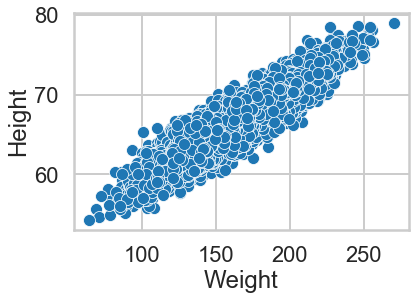

In [7]:
# you turn 
sns.scatterplot(x='Weight', y='Height', data=df_log)
plt.xlabel('Weight')
plt.ylabel('Height')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [9]:
# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(df_log[['Height', 'Weight']].values,
                                              (df_log.Gender == 'Male').values, random_state=5)

clf = LogisticRegression(solver='lbfgs')

# Fit the model on the training data
clf.fit(Xlr, ylr)

# Print the accuracy from the testing data.
print(accuracy_score(clf.predict(Xtestlr), ytestlr))

# Same as print(clf.score(Xtestlr, ytestlr))

0.9252


### Tuning the Model
The model has some hyperparameters we can tune for hopefully better performance. For tuning the parameters of your model, you will use a mix of cross-validation and grid search. In Logistic Regression, the most important parameter to tune is the regularization parameter C. Note that the regularization parameter is not always part of the logistic regression model.
<br><br>
The regularization parameter is used to control for unlikely high regression coefficients, and in other cases can be used when data is sparse, as a method of feature selection.
<br><br>
You will now implement some code to perform model tuning and selecting the regularization parameter $C$.
<br><br>
We use the following cv_score function to perform K-fold cross-validation and apply a scoring function to each test fold. In this incarnation we use accuracy score as the default scoring function.

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

def cv_score(clf, x, y, score_func = accuracy_score):
    result = 0
    nfold = 5
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x[train], y[train]) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
        
        # result += clf.score(x[test], y[test]) same as above
    return result / nfold # average

Below is an example of using the cv_score function for a basic logistic regression model without regularization.

In [11]:
clf = LogisticRegression(solver='lbfgs')
score = cv_score(clf, Xlr, ylr) # test accuarcy in K fold cross validation, clf.score(Xlr, ylr) training accuracy
print(score)

0.9172


In [12]:
# Using cross_val score
from sklearn.model_selection import cross_val_score
cv_score1 = cross_val_score(clf, Xlr, ylr, cv=5)
print(np.mean(cv_score1)) # different from cv_score?

0.9168


### Checkup Exercise Set II
Exercise: Implement the following search procedure to find a good model
* You are given a list of possible values of `C` below
* For each C:
    1. Create a logistic regression model with that value of C
    2. Find the average score for this model using the `cv_score` function **only on the training set** `(Xlr, ylr)`
* Pick the C with the highest average score
Your goal is to find the best model parameters based *only* on the training set, without showing the model test set at all (which is why the test set is also called a *hold-out* set).

In [13]:
# the grid of parameter to search over
Cs = [0.001, 0.1, 1, 10, 100]

# your turn

# use cv_score, different results from GridSearchCV!!
scores = {}

for i in Cs:
    logreg1 = LogisticRegression(C=i, solver='lbfgs')
    scores[i] = cv_score(logreg1, Xlr, ylr)
print(scores)
max(scores, key=scores.get)


{0.001: 0.9122666666666668, 0.1: 0.9172, 1: 0.9172, 10: 0.9172, 100: 0.9172}


0.1